In [1]:
import torch
import MiniFL as mfl

In [2]:
NUM_CLIENTS = 5
NUM_FEATURES = 300

In [3]:
GD_STEPS = 100

master_fn, client_fns = mfl.tasks.get_w8a_regression_fns(
    data_path="w8a",
    num_clients=NUM_CLIENTS,
    batch_size=-1,
)

master, clients = mfl.algorithms.get_gd_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma_multiplier=1,
)

GD_METRICS = mfl.algorithms.run_algorithm(master, clients, GD_STEPS)

100%|██████████| 100/100 [00:03<00:00, 33.11it/s]


In [4]:
MARINA_STEPS = 1000

master_fn, client_fns = mfl.tasks.get_w8a_regression_fns(
    data_path="w8a",
    num_clients=NUM_CLIENTS,
    batch_size=-1,
)

master, clients = mfl.algorithms.get_marina_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    compressors=[mfl.compressors.RandPUnbiasedCompressor(0.005) for _ in range(NUM_CLIENTS)],
    p=0.01,
    gamma_multiplier=1,
)

MARINA_METRICS = mfl.algorithms.run_algorithm(master, clients, MARINA_STEPS)

100%|██████████| 1000/1000 [00:20<00:00, 48.85it/s]


In [5]:
COCKTAIL_STEPS = 1000

master_fn, client_fns = mfl.tasks.get_w8a_regression_fns(
    data_path="w8a",
    num_clients=NUM_CLIENTS,
    batch_size=-1,
)

master, clients = mfl.algorithms.get_cocktailgd_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma=1,
    rand_p=0.2,
    top_p=0.2,
    # p=0.1,
)

COCKTAIL_METRICS = mfl.algorithms.run_algorithm(master, clients, COCKTAIL_STEPS)


100%|██████████| 1000/1000 [00:22<00:00, 45.44it/s]


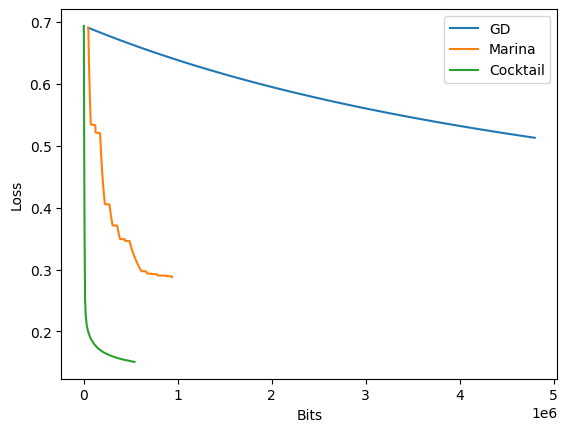

In [6]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received for metrics in GD_METRICS], [metrics.value for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received for metrics in MARINA_METRICS], [metrics.value for metrics in MARINA_METRICS], label="Marina")
plt.plot([metrics.total_bits_received for metrics in COCKTAIL_METRICS], [metrics.value for metrics in COCKTAIL_METRICS], label="Cocktail")

plt.xlabel("Bits")
plt.ylabel("Loss")
plt.legend()

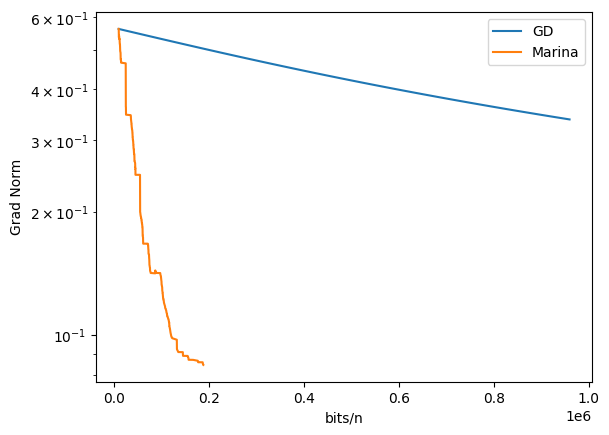

In [7]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in GD_METRICS], [metrics.grad_norm for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in MARINA_METRICS], [metrics.grad_norm for metrics in MARINA_METRICS], label="Marina")
plt.yscale("log")

plt.xlabel("bits/n")
plt.ylabel("Grad Norm")
plt.legend()